I've always suspected that condos and small starter homes were more susceptible to run-ups and crashes than single family homes and other larger dwellings. Based on this idea, I thought it'd be fun to do some housing price predictions.

The dataset I'm examining consists of real estate transactions in the state of Connecticut from 2001 to the third quarter of 2023. Each row is a real estate transaction. Since it's statewide, it provides a nice sample of property types across different income levels, city vs. rural, and other characteristics.

There might be some cases where certain types of luxury homes are underrepresented due to low supply. But for the most part, the dataset seems like a reasonable representation of real estate in the United States.

The data is from Connecticut's Office of Policy and Management. I got the data from data.gov at this link: https://catalog.data.gov/dataset/real-estate-sales-2001-2018

**Independent Variables:**

*  'Residential Type': This can be condo, single family, two family, and three family. Multi-family functions more like mini apartment buildings, so I will be removing them. I want to compare apples to apples. Townhomes fall under single family in this dataset. That is more logical than falling under condos.  
*   'Town': This can be a useful piece of information for determining price. Some towns are wealthy and some are lower-income on average.
*   'Assessed Value': Tax assessments are the prices which the local governments use to determine property taxes. It should have a pretty close relationship with sale amount over time.
*   'date recorded' and 'list_year' represent the dates on which transactions occurred or the year in which the transactions were listed

**Dependent Variables:**

*   'sale amount'. We want to predict the sale amount and then compare the variance across residential property types. We will be using residuals as a measure of the predictability of house prices.

**Hypothesis: sale amount ~ Residential type + town + year + assessed_value**

My hypothesis is as follows: As house size decreases, the predictability of sales price of housing decreases. In other words, less expensive homes are more prone to price swings and more difficult to forecast. An implicit assumption in my hypothesis is that single family homes are larger than condos, which is likely true most of the time. Another implicit assumption is that more expensive homes tend to be larger than less expensive homes.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 20) 

df = pd.read_csv('Real_Estate_Sales_2001-2023_GL.csv')


C:\Users\Admin\AppData\Local\Temp\ipykernel_50880\1520421387.py:21: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Real_Estate_Sales_2001-2023_GL.csv')


I use these colors later in my analysis. Condo color will be teal and single family color will be a dark orange. I am listing these here so I can change all instances of condo or single family color from a central location.

In [3]:
condo_color = '#26CCC2'
single_family_color = '#DD8452'

Let's see the columns:

In [4]:
df.head(5)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.463,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN,NaN,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,0.4965,Residential,Condo,NaN,NaN,NaN,POINT (-72.879115982 41.773452988)


Initial shape is 1,141,722 rows, 14 columns

In [5]:
print(df.shape)

(1141722, 14)


In [6]:
df.describe()

,Serial Number,List Year,Assessed Value,Sale Amount
count,1.141722e+06,1.141722e+06,1.141722e+06,1.141722e+06
mean,5.457366e+05,2.011673e+03,2.833275e+05,4.104510e+05
std,7.450110e+06,7.018679e+00,1.656128e+06,5.048996e+06
min,0.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00
25%,3.090300e+04,2.005000e+03,8.991000e+04,1.461000e+05
50%,9.016000e+04,2.012000e+03,1.419800e+05,2.375000e+05
75%,1.801550e+05,2.018000e+03,2.300600e+05,3.837500e+05
max,2.000500e+09,2.023000e+03,8.815100e+08,5.000000e+09


There were several columns missing so many values it's probably better to just drop them entirely: Non Use Code, Assessor Remarks, OPM remarks, and Location.

The dataset is also unfortunately missing "Residential Type" from 2001 to September 2006. So I will not be analyzing that time period. Having the residential type is crucial since it is one of my independent variables.

In [7]:
df.isnull().sum()

Serial Number             0
List Year                 0
Date Recorded             2
Town                      0
Address                  51
Assessed Value            0
Sale Amount               0
Sales Ratio               0
Property Type        382446
Residential Type     402918
Non Use Code         816915
Assessor Remarks     960632
OPM remarks         1127376
Location             800481
dtype: int64

**Sales Ratio:**

This is Tax Assessed Value divided by Sale Amount. If a property sells for \$400k and has a tax assessment value of \$300k, that would be a 0.75 sales ratio. It's normal for tax assessments to lag market values. The median sales ratio is 0.6 on this dataset.

Extremely high and extremely low values represent unrealistic transactions, such as properties that have a tax assessment of \$0 or a property that was bought at a bankruptcy auction for \$1. These values must be removed.

In [8]:
print(df['Sales Ratio'].describe())
print(df.shape)


count     1141722.0
unique     561008.0
top             0.0
freq         8765.0
Name: Sales Ratio, dtype: float64
(1141722, 14)


Extreme outliers to the right side are blowing up the mean.

In [9]:
df = df.rename(columns={"Sales Ratio": "sales_ratio"})

# Need to change Sales Ratio to floats first
df["sales_ratio"] = pd.to_numeric(df["sales_ratio"], errors='coerce')

# Calculate statistics
mean = df['sales_ratio'].mean()
median = df['sales_ratio'].median()
std = df['sales_ratio'].std()

print(f"Mean: {mean:.3f}")
print(f"Median: {median:.3f}")
print(f"Standard Deviation: {std:.3f}")

Mean: 9.279
Median: 0.605
Standard Deviation: 1766.534


This time, I am excluding the top 1% of the values to get rid of the most extreme values.

The mean drops from 9.279 to 0.709, much closer to the median.

The box plot shows that there are many outliers in the top quartile of data.

Mean: 0.709
Median: 0.602
Standard Deviation: 0.579

Mean - 3 std cutoff re-specified to 0!


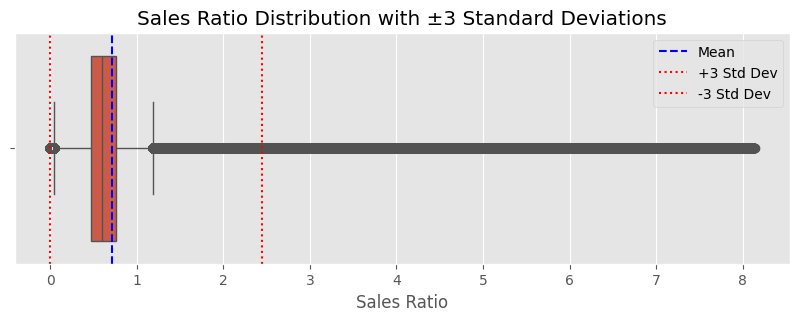

Mean: 0.709
Mean + 3 std deviations: 2.445
Mean - 3 std deviations: 0.000


In [10]:
# Trimming the highest 1% to avoid extreme outliers to the right
df = df[df['sales_ratio'] < df['sales_ratio'].quantile(0.99)].copy()

# Calculate statistics
mean = df['sales_ratio'].mean()
median = df['sales_ratio'].median()
std = df['sales_ratio'].std()

print(f"Mean: {mean:.3f}")
print(f"Median: {median:.3f}")
print(f"Standard Deviation: {std:.3f}")

# Box plot
plt.figure(figsize=(10, 3))
sns.boxplot(x=df['sales_ratio'], orient='h')

# Mean line
plt.axvline(mean, color='blue', linestyle='--', label='Mean')

upper_threshold = mean + 3*std
lower_threshold = mean - 3*std
if lower_threshold < 0:
  lower_threshold = 0
  print("\nMean - 3 std cutoff re-specified to 0!")

# ±3 standard deviation lines
plt.axvline(upper_threshold, color='red', linestyle=':', label='+3 Std Dev')
plt.axvline(lower_threshold, color='red', linestyle=':', label='-3 Std Dev')

plt.title('Sales Ratio Distribution with ±3 Standard Deviations')
plt.xlabel('Sales Ratio')
plt.legend()
plt.show()

print(f"Mean: {mean:.3f}")
print(f"Mean + 3 std deviations: {upper_threshold:.3f}")
print(f"Mean - 3 std deviations: {lower_threshold:.3f}")

**Data cleaning plan**

Delete unnecessary columns:

*   Property Type
*   Non Use Code
*   Assessor Remarks
*   OPM Remarks
*   Location
*   Serial number

Rename columns:

| Original Column Name     | New Column Name |
|--------------------------|------------------------|
| List Year                | list_year              |
| Date Recorded            | date_recorded          |
| Town                     | town                   |
| Address                  | street_address         |
| Assessed Value           | tax_assessed_value     |
| Sale Amount              | sale_amount            |
| Sales Ratio              | sales_ratio            |
| Residential Type         | residential_type       |




Other:

*   Delete any rows with sales ratio less than 0.1 or greater than 2.445, 3 standard deviations above the mean. Doing this rids us of 2 types of extreme outliers: (1) Properties bought for \$1 or other low amounts at bankruptcy auctions and (2) Properties with \$0 or other incorrect tax assessed values.  
*   Delete rows where sale_amount is less than \$5k
*   Remove residential_type values other than "Condo" or "Single Family"
*   Delete any rows that are missing date_recorded or street_address
*   Delete errant symbols from street address

In [11]:
# Delete unneeded columns
df = df.drop(columns=["Property Type", "Non Use Code", "Assessor Remarks", "OPM remarks", "Location", "Serial Number"], errors='ignore')

# Rename columns
df = df.rename(columns={
    "List Year": "list_year",
    "Date Recorded": "date_recorded",
    "Town": "town",
    "Address": "street_address",
    "Assessed Value": "tax_assessed_value",
    "Sale Amount": "sale_amount",
    "Residential Type": "residential_type",
})

# Removing values of sale_amount that are under 5000. These values are unlikely to represent "typical" transactions.
df = df[df['sale_amount'] >= 5000]

# Delete any row where sales_ratio is less than 0.1 or greater than 2.445)
df = df[(df["sales_ratio"] >= 0.1) & (df["sales_ratio"] <= 2.445)]

# Delete unnecessary residential_types:
df = df[df["residential_type"].isin(["Condo", "Single Family"])]

# Delete rows where date_recorded or street_address are missing
df = df.dropna(subset=["date_recorded", "street_address"])

# Change these columns to int. No reason to keep them as floats
df['tax_assessed_value'] = df['tax_assessed_value'].astype(int)
df['sale_amount'] = df['sale_amount'].astype(int)

# Here, a row has a number stored in the "street_address" column
df = df[df['street_address'] != '2350000']

# There are dates stored incorrectly. For example, 07/11/0024 was entered as a date. The intent was likely 7/11/2024.
df['date_recorded'] = pd.to_datetime(df['date_recorded'], errors='coerce', format='%m/%d/%Y')

# Drop null dates and dates before 2006.
df = df.dropna(subset=['date_recorded'])

# I had to re-convert 'date_recorded' to a datetime object. dropna() kept converting it back to object.
df.loc[:, 'date_recorded'] = pd.to_datetime(df['date_recorded'], errors='coerce', format='%m/%d/%Y')

df = df.loc[df['date_recorded'].dt.year >= 2006]

# Cleaning a bunch of other symbols from the street address column. some dollar amounts/dates
df['street_address'] = df['street_address'].str.replace(r'[.,]', '', regex=True)
df = df[~df['street_address'].str.match(r'^\d+$')]
df = df[~df['street_address'].str.contains(r'\$', regex=True)]
df = df[~df['street_address'].str.contains(r'/', regex=True)]
df = df[~df['street_address'].str.contains(r'\?', regex=True)]

# Removing one row with unknown town
df = df[df['town'] != '***Unknown***']

**Post-cleaning features**

One row in the dataset represents a real estate transaction in the state of Connecticut.

Here are the columns:

*   **list_year**: The year the property was listed for sale.
*   **date_recorded**: When the sale actually occurred.
*   **town**: Town name
*   **street_address**: The number and street name of the property
*   **tax_assessed_value**: The tax assessment of the property value. Property assessments typically rise slowly and are usually lower than market values.
*   **sale_amount**: The sale price of the property
*   **sales_ratio**: The ratio of tax_assessed_value (numerator) divided by sale_amount (denominator). Typically a ratio below 1, but can fluctuate based on market conditions and upon characteristics of the property.
*   **residential_type**: The type of the property, such as single family or condo

**List year:**

This is a plot of real estate transactions by year. We saw a drop for the 4-5 years following the collapse of the real estate boom of the 2000's. Volume then steadily recovered, peaking during the pandemic home-buying boom.

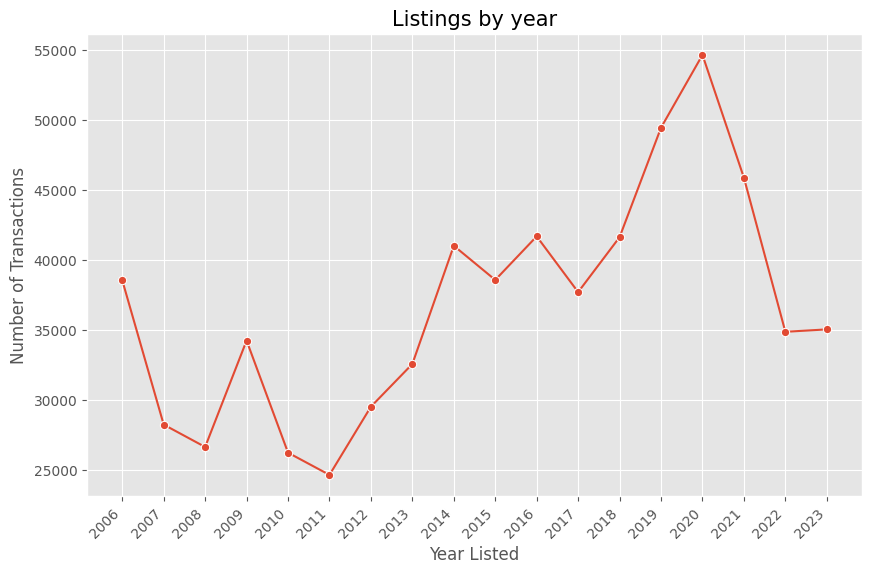

In [12]:
# Count the number of listings per year
listings_by_year = df['list_year'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=listings_by_year.index, y=listings_by_year.values, marker='o')

# We want ints for years
plt.xticks(ticks=list(listings_by_year.index), labels=list(map(int, listings_by_year.index)), rotation=45, ha='right')

plt.title('Listings by year', fontsize=15)
plt.xlabel('Year Listed', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()

**Frequently occurring towns:**

These are the top 20 most frequently occurring towns in the dataset. Stamford had the most real estate transactions in Connecticut during our time period.

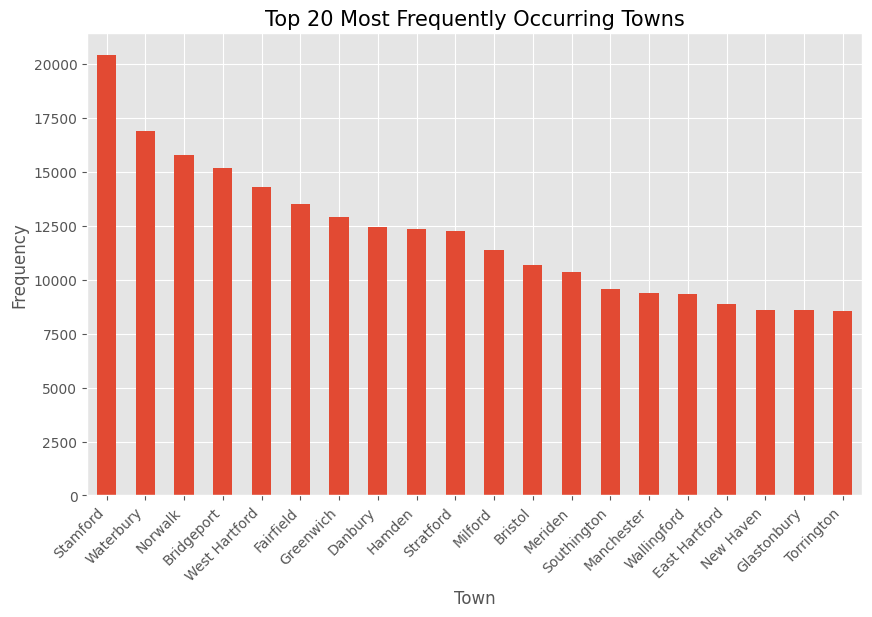

In [13]:
# Plot the top 20 towns
top_20_towns = df['town'].value_counts().head(20)

plt.figure(figsize=(10, 6))
top_20_towns.plot(kind='bar')
plt.title('Top 20 Most Frequently Occurring Towns', fontsize=15)
plt.xlabel('Town', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

**Top 30 towns by median sale amount:**

These are the top 30 towns by median sale price. 4 towns from the top 20 most frequently occurring towns list also appear here. There are four towns that are clearly more pricey than the rest of the towns. They are colored blue in this plot.

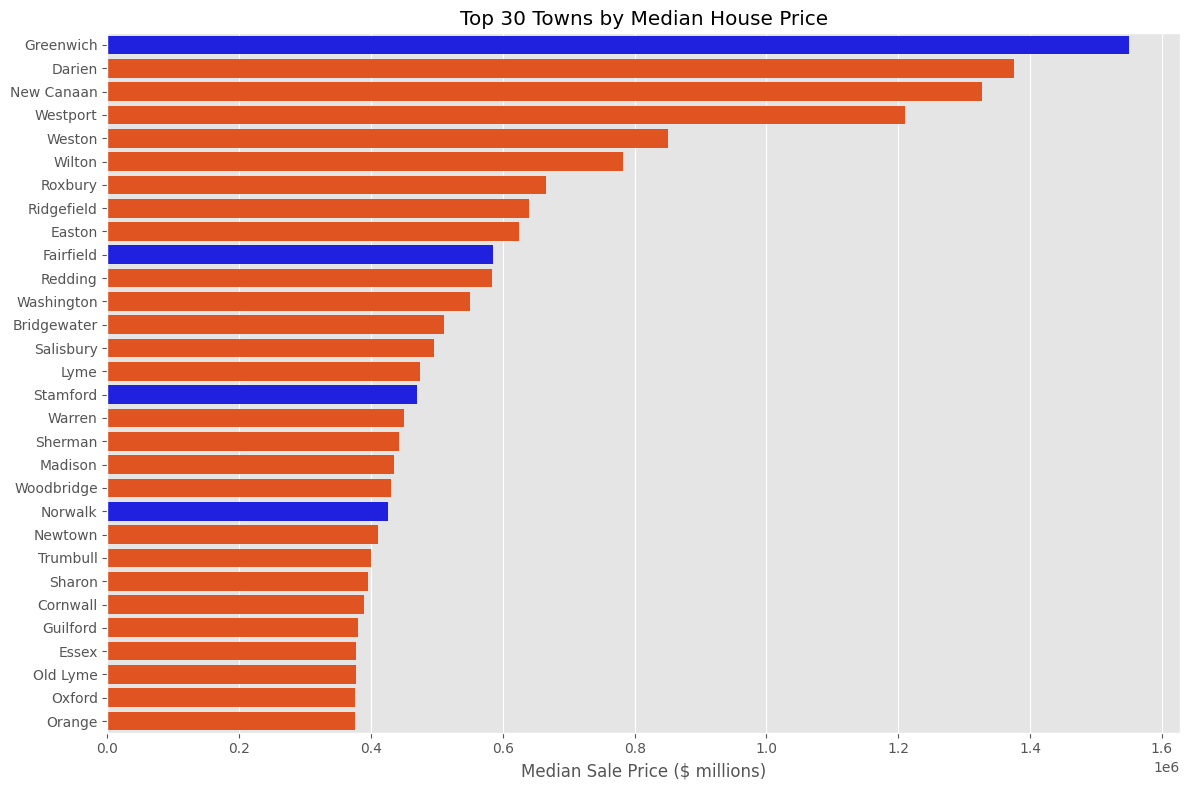

In [14]:
# Plot of median prices by town
top_20_town_names = set(top_20_towns.index)

median_prices = df.groupby('town')['sale_amount'].median()
top_30_towns = median_prices.sort_values(ascending=False).head(30)

# Blue if in top 20 frequent towns also. Else red
colors = [
    'blue' if town in top_20_town_names else 'orangered'
    for town in top_30_towns.index
]

plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_30_towns.values,
    y=top_30_towns.index,
    hue=top_30_towns.index,
    palette=colors,
    legend=False,
)
plt.xlabel('Median Sale Price ($ millions)')
plt.ylabel('')
plt.title('Top 30 Towns by Median House Price')
plt.tight_layout()
plt.show()


**Town frequency vs median sale amount:**

Town Frequency vs Median Sale Price: The bulk of transactions appear to be for less than \$400k in towns that occur less than 10,000 times in the dataset. The two features are also uncorrelated, with an R-squared of 0.01 between these two features.

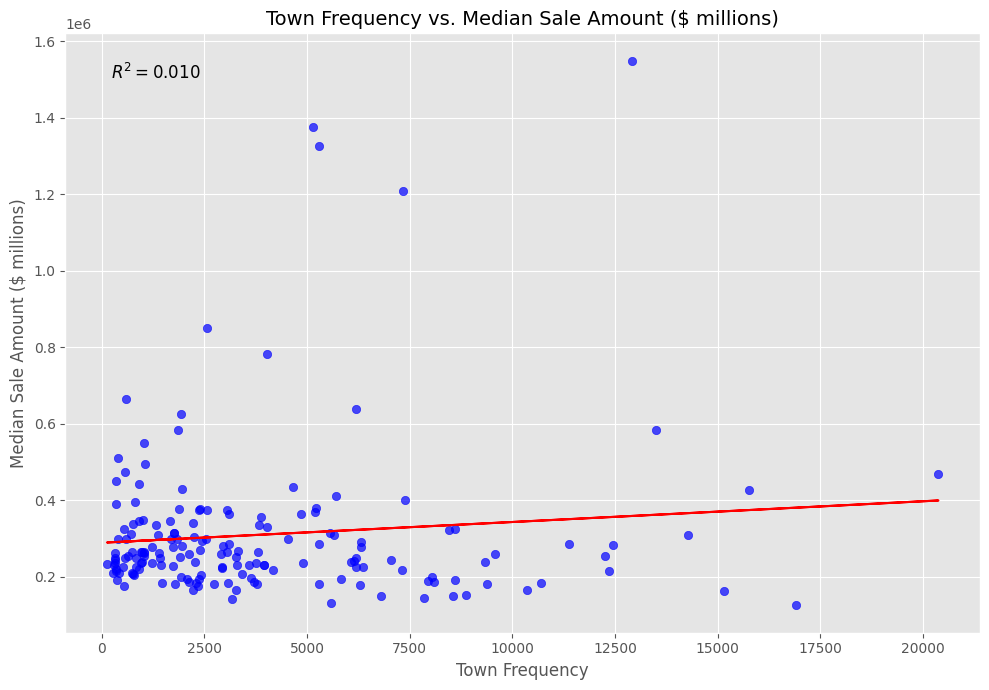

In [15]:
from sklearn.metrics import r2_score

# Frequency of each town
town_counts = df['town'].value_counts()

# Median sale price per town
town_medians = df.groupby('town')['sale_amount'].median()

# Combine into a single DataFrame
town_summary = pd.DataFrame({
    'frequency': town_counts,
    'median_sale_amount': town_medians
}).dropna()

x = town_summary['frequency'].values
y = town_summary['median_sale_amount'].values

# Fit line
slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

# Calculate R-squared
r2 = r2_score(y, y_pred)

plt.figure(figsize=(10, 7))
plt.scatter(x,
            y,
            alpha=0.7,
            color='blue',
            )

# Regression line
plt.plot(x, y_pred, color='red')

plt.xlabel('Town Frequency', fontsize=12)
plt.ylabel('Median Sale Amount ($ millions)', fontsize=12)
plt.title('Town Frequency vs. Median Sale Amount ($ millions)', fontsize=14)

# Add R-squared annotation
plt.text(
    0.05, 0.95,
    f'$R^2 = {r2:.3f}$',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

**tax_assessed_value:**

Tax assessed value is the value of the property for property tax purposes. The distribution appears to roughly approximate a normal distribution with a right skew. Tax assessed value is typically lower than sale amount.

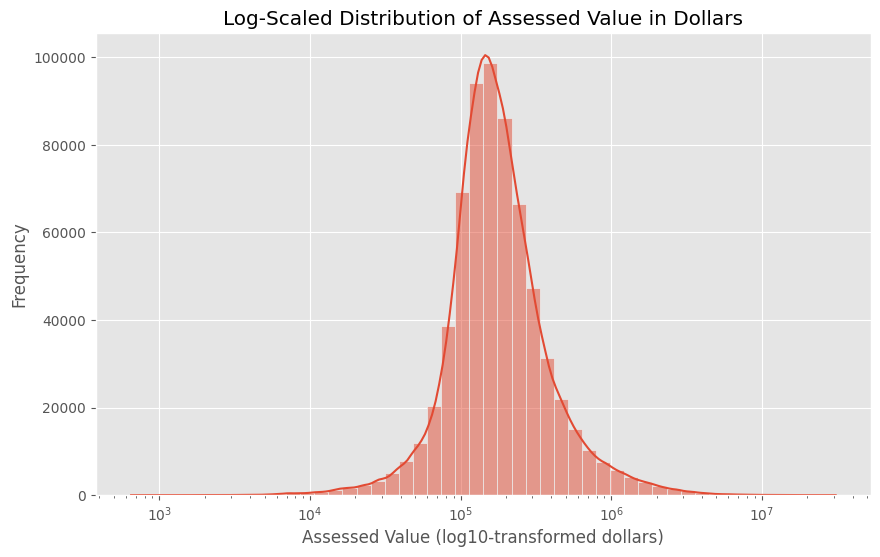

In [16]:
# Plots for tax_assessed_value
plt.figure(figsize=(10, 6))

# log-scaled distribution to compare
sns.histplot(df['tax_assessed_value'],
             bins=50,
             kde=True,
             log_scale=True,
             )
plt.title('Log-Scaled Distribution of Assessed Value in Dollars')
plt.xlabel('Assessed Value (log10-transformed dollars)')
plt.ylabel('Frequency')
plt.show()

**sale_amount:**

This is the sale price of the property. Just like the tax assessment distribution, the feature appears to be approximately normally distributed with a right skew.


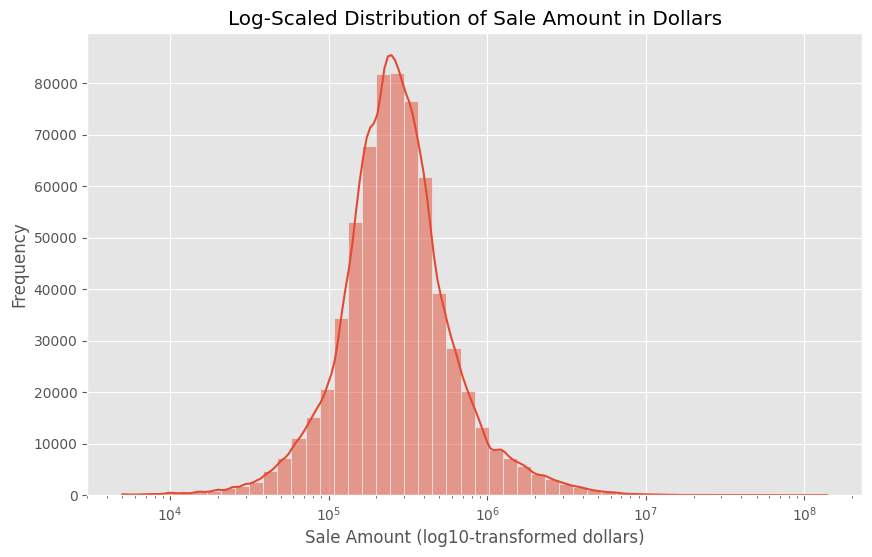

In [17]:
# Plot for sale_amount (log-scaled)
plt.figure(figsize=(10, 6))

sns.histplot(df['sale_amount'],
             bins=50,
             kde=True,
             log_scale=True,
             )
plt.title('Log-Scaled Distribution of Sale Amount in Dollars')
plt.xlabel('Sale Amount (log10-transformed dollars)')
plt.ylabel('Frequency')
plt.show()

**sales_ratio:**

The ratio of tax assessed value (numerator) divided by sale amount (denominator). Typically a ratio below 1, but can fluctuate based on market conditions and upon characteristics of the property. We cut off a bunch of the outliers by limiting the sales ratio range to (0.1, 2.445). The upper cutoff was mean + 3 standard deviations, while the lower cutoff was a low number chosen to cut out nonsense transactions such as tax assessed values of $0 or $1. Even after these cutoffs, there are a lot of outliers to the right.

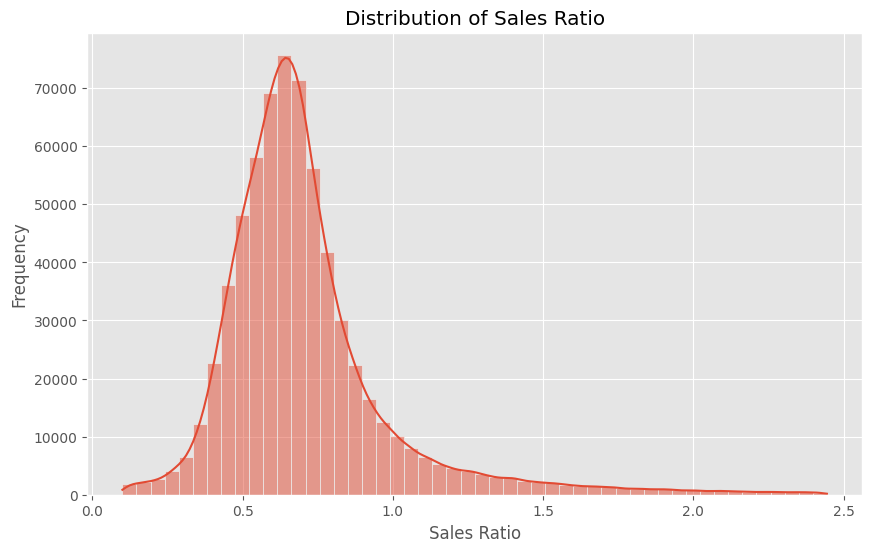

In [18]:
# Plot for sales_ratio

plt.figure(figsize=(10, 6))
sns.histplot(df['sales_ratio'], bins=50, kde=True)
plt.title('Distribution of Sales Ratio')
plt.xlabel('Sales Ratio')
plt.ylabel('Frequency')
plt.show()

**residential_type:**

The type of the property, such as single family or condo. There are approximately four times more single family homes than condos in our dataset. That makes sense, since we typically see more single family homes than condos out in the wild.

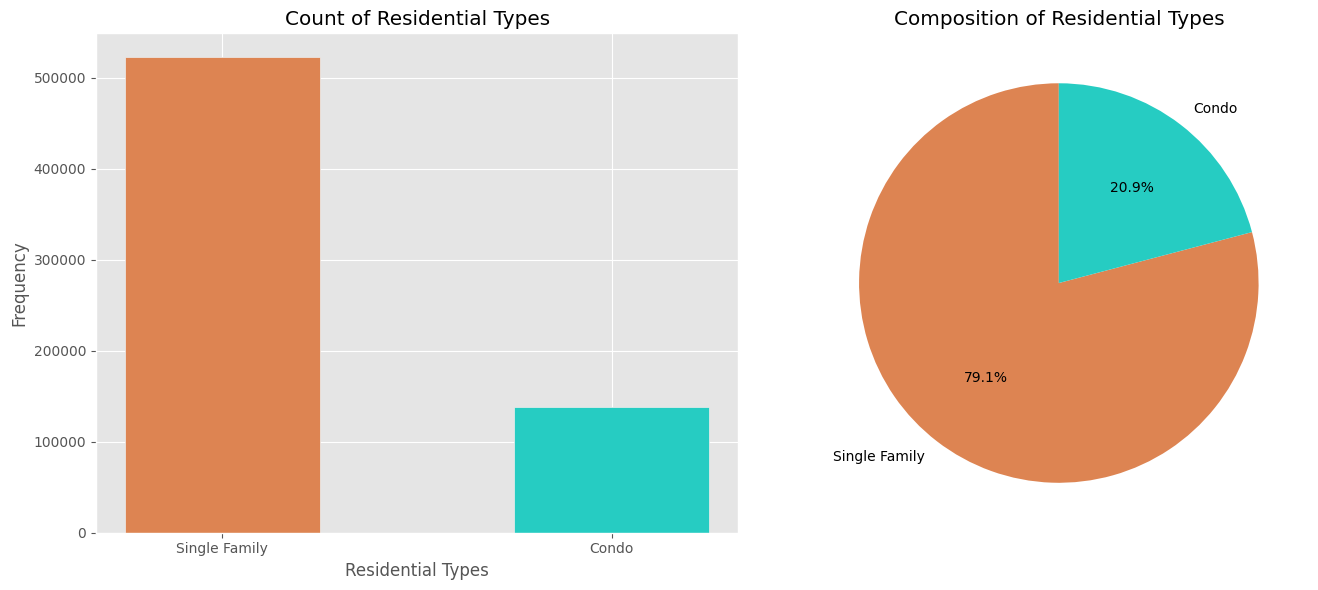

In [19]:
# Count the number of occurrences for each residential type
counts = df['residential_type'].value_counts()

# Plots for residential type
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df,
             x='residential_type',
             hue='residential_type',
             palette=[single_family_color, condo_color],
             shrink=0.5,
             alpha=1,
             legend=False,
             ax=ax[0]
             )

ax[0].set_title('Count of Residential Types')
ax[0].set_xlabel('Residential Types')
ax[0].set_ylabel('Frequency')

# Plot the pie chart
ax[1].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=[single_family_color, condo_color])
ax[1].set_title('Composition of Residential Types')
ax[1].set_ylabel('')  # Hide y-label for a cleaner look

plt.tight_layout()
plt.show()


**Seasonality:**

As expected, the peak selling months are in the Summer, with a gradual ramping up period in the Spring. This is how the curve looks for a cold state like Connecticut. It might be flatter in warmer places such as Miami or Houston, where Winters are far milder.

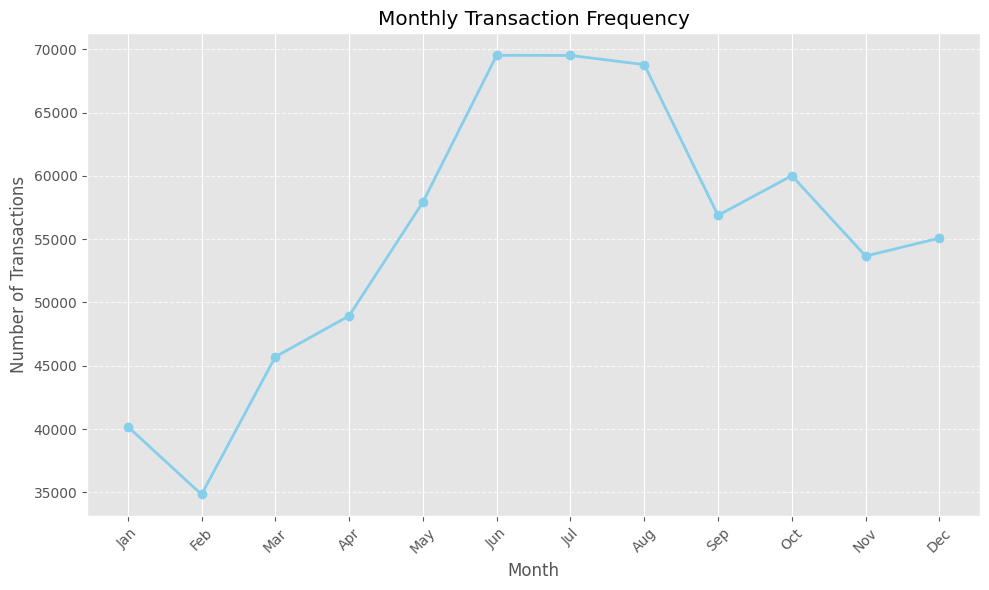

In [20]:
# Plot of monthly transaction frequency

df['month'] = df['date_recorded'].dt.month
monthly_transactions = df.groupby('month').size()
plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line', color='skyblue', marker='o', linewidth=2)
plt.title('Monthly Transaction Frequency')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(
    ticks=range(1, 13),
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    rotation=45
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Relationship between tax assessed value and sale amount:**

I plotted tax assessed value against sale amount to see what the relationship might look like. There is a strong correlation between the two, with an R-squared of 0.8. We can see that the vast majority of transactions occur in the lower left corner of this chart.

The median sales ratio of our dataset is 0.6, which means that sale amount is meaningfully larger than tax assessed value for our average property. We can see, however, that there are a lot of outliers with tax assessed values that are much higher than sale amounts. This also helps explain the right skew on the distribution of the sales ratio.

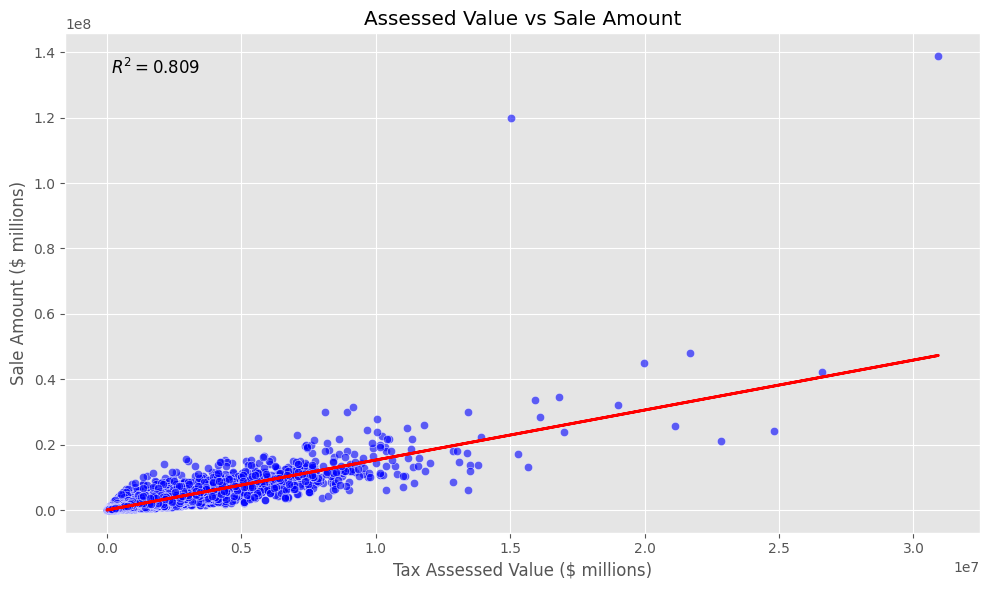

In [21]:
from sklearn.metrics import r2_score

# Drop rows with missing values just to be safe
plot_df = df[['tax_assessed_value', 'sale_amount']].dropna()

x = plot_df['tax_assessed_value'].values
y = plot_df['sale_amount'].values

# Fit line
slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

# Calculate R-squared
r2 = r2_score(y, y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x,
                y=y,
                alpha=0.6,
                color='blue')

# regression line
plt.plot(x, y_pred, color='red', linewidth=2)

plt.title('Assessed Value vs Sale Amount')
plt.xlabel('Tax Assessed Value ($ millions)')
plt.ylabel('Sale Amount ($ millions)')

# Add R-squared annotation
plt.text(
    0.05, 0.95,
    f'$R^2 = {r2:.3f}$',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

**Median Sale Price by Year:**

House prices fell after the great financial crisis of 2008 and stayed flat for roughly a decade. Home prices then surged shortly before the pandemic, climbing sharply. We currently have major affordability issues in the US. Interestingly, condos seem to have more muted price action in both directions.

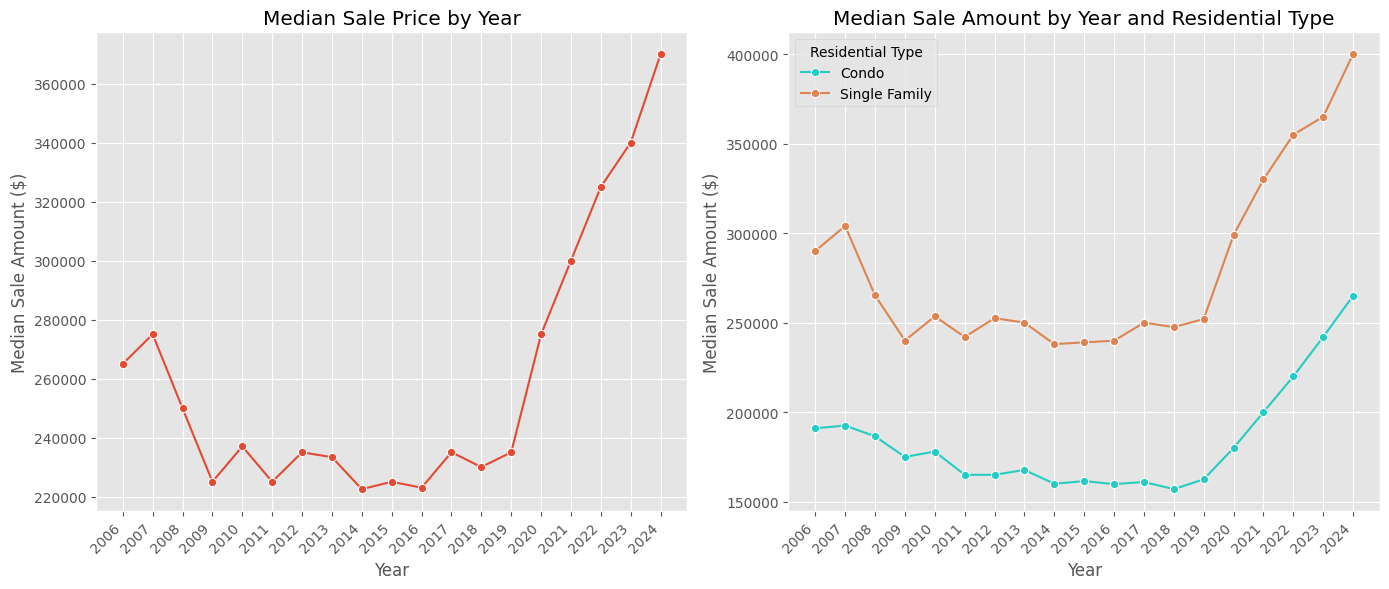

In [22]:
# Plots of median sale_amount by year for observing price action
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

df['year'] = df['date_recorded'].dt.year

median_sales_by_year = (
    df.groupby("year")["sale_amount"]
      .median()
      .reset_index()
      .sort_values("year")
)

sns.lineplot(
    data=median_sales_by_year,
    x="year",
    y="sale_amount",
    marker="o",
    ax=ax[0]
)

# Get rid of floats on X axis.
ax[0].set_xticks(median_sales_by_year['year'],
                 labels=median_sales_by_year['year'].astype(int),
                 rotation=45,
                 ha='right'
                 )

ax[0].set_title("Median Sale Price by Year")
ax[0].set_ylabel("Median Sale Amount ($)")
ax[0].set_xlabel("Year")

# Plot median sale amount by year and residential type
avg_price_by_year_type = (
    df.groupby(["year", "residential_type"])["sale_amount"]
      .median()
      .reset_index()
      .sort_values("year")
)

sns.lineplot(
    data=avg_price_by_year_type,
    x="year",
    y="sale_amount",
    hue="residential_type",
    palette={
        "Single Family": single_family_color,
        "Condo": condo_color,
    },
    marker="o",
    ax=ax[1]
)

ax[1].set_xticks(sorted(avg_price_by_year_type['year'].unique()),
                 labels=median_sales_by_year['year'].astype(int),
                 rotation=45,
                 ha='right'
                 )

ax[1].set_title("Median Sale Amount by Year and Residential Type")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Median Sale Amount ($)")
ax[1].legend(title="Residential Type")

plt.tight_layout()
plt.show()


**Sales ratio by year:**

Sales ratio is the ratio of tax assessed value (numerator) vs the final sale amount (denominator). A lower sales ratio indicates the market price it outpacing the tax assessment by more. That means bidders are potentially paying a higher premium above "fair value" (which itself is a hard-to-measure number and not actually what's measured by tax assessment).

The highest sales ratio was in 2011. That's when sales prices were closest to tax assessed values. The ratio fell sharply over the ensuing decade. One big possibility is that sales prices are zooming higher than tax assessments and homes are becoming increasingly unaffordable.


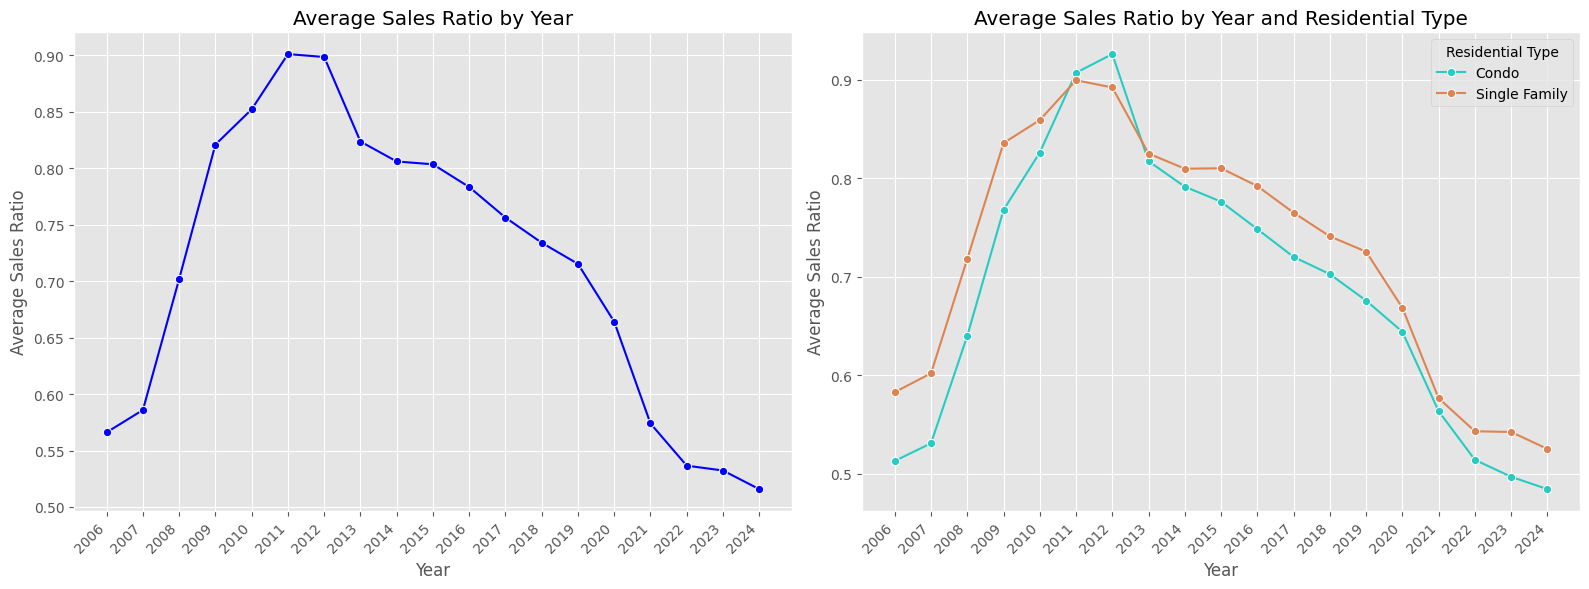

In [23]:
# Side-by-side plots of sales ratio

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot of average sales ratio by year
average_sales_ratio = df.groupby('year')['sales_ratio'].mean()

sns.lineplot(
    x=average_sales_ratio.index,
    y=average_sales_ratio.values,
    marker='o',
    color='b',
    ax=ax[0]
)

ax[0].set_xticks(ticks=list(average_sales_ratio.index),
                 labels=list(map(int, average_sales_ratio.index)),
                 rotation=45,
                 ha='right'
                 )

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Average Sales Ratio')
ax[0].set_title('Average Sales Ratio by Year')

# Plot of average sales ratio by year and residential type
sales_ratio_by_year_type = (
    df.groupby(['year', 'residential_type'])['sales_ratio']
      .mean()
      .reset_index()
)

sns.lineplot(
    data=sales_ratio_by_year_type,
    x='year',
    y='sales_ratio',
    hue='residential_type',
    marker='o',
    palette={
        "Single Family": single_family_color,
        "Condo": condo_color,
    },
    legend=True,
    ax=ax[1]
)

ax[1].set_title('Average Sales Ratio by Year and Residential Type')

ax[1].set_xticks(
    ticks=sorted(sales_ratio_by_year_type['year'].unique()),
    labels=sorted(sales_ratio_by_year_type['year'].unique().astype(int)),
    rotation=45,
    ha='right'
)

ax[1].set_xlabel('Year')
ax[1].set_ylabel('Average Sales Ratio')

ax[1].legend(title='Residential Type')

plt.tight_layout()
plt.show()


**Summary stats of sales ratio by quintile:**

Quintiles 1 through 4 have relatively similar values. Quintile 5 has a much higher standard deviation, which confirms what the charts have shown: there are many outliers in that quintile.

| sales_ratio_quintile | mean  | median | std  |
|----------------------|-------|--------|------|
| 1                    | 0.425 | 0.449  | 0.084|
| 2                    | 0.570 | 0.572  | 0.028|
| 3                    | 0.658 | 0.658  | 0.024|
| 4                    | 0.757 | 0.753  | 0.037|
| 5                    | 1.139 | 1.011  | 0.335|

In [24]:
# print summary stats of sales ratio by quintile for exact values
df['sales_ratio_quintile'] = pd.qcut(df['sales_ratio'], 5, labels=False) + 1

summary_stats = df.groupby('sales_ratio_quintile')['sales_ratio'].agg(
    mean='mean',
    median='median',
    std='std'
).reset_index()

# print("\nPrinting summary stats of sales ratio by quintile...")
# print(summary_stats.round(3).to_string(index=False))

**Mean and median sale amount by residential type:**

Single family homes are on average more expensive than condos in this dataset.That makes sense, since single family homes tend to be larger than condos.

| residential_type | mean    | median  |
|-----------------|---------|---------|
| Condo           | 247,074 | 185,000 |
| Single Family   | 429,308 | 280,000 |

In [25]:
avg_price_by_residential_type = (
    df.groupby('residential_type')['sale_amount']
      .agg(['mean', 'median'])
      .reset_index()
)

# Add commas to numeric columns
avg_price_by_residential_type[['mean', 'median']] = (
    avg_price_by_residential_type[['mean', 'median']]
        .map(lambda x: f"{x:,.0f}")
)

# print("\nPrinting mean/median prices by residential type...")
# print(avg_price_by_residential_type.to_string(index=False))

**Sale Amount by Residential Type**

Interestingly, single family homes seem to have a very fat right tail while the condos don't seem to have the same number of outliers to the right. This means there are more outliers in the Single Family group than in the Condo group, reflecting greater variability in Single Family than in Condo.



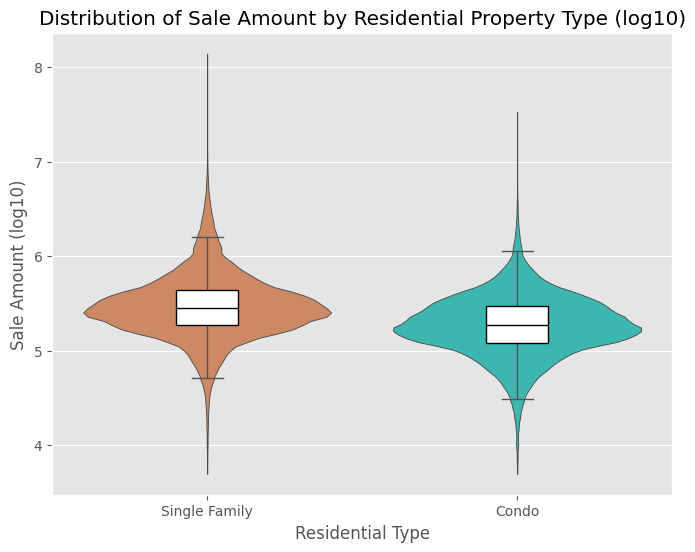

In [26]:
# Distribution of sale amount by residential type

# Log transform before plotting
df["log_sale_amount"] = np.log10(df["sale_amount"])

plt.figure(figsize=(8, 6))

sns.violinplot(
    data=df,
    x="residential_type",
    y="log_sale_amount",
    hue="residential_type",
    inner=None,
    cut=0,
    palette={
    "Single Family": single_family_color,
    "Condo": condo_color,
    },
    legend=False,
)

# Box plot with white boxes for visual clarity
sns.boxplot(
    data=df,
    x="residential_type",
    y="log_sale_amount",
    width=0.2,
    showcaps=True,
    boxprops={
        "facecolor": "white",
        "edgecolor": "black",
        "zorder": 3,
        },
    medianprops={
        "color": "black",
        "linewidth": 1,
        "zorder": 4,
        },
    showfliers=False
)

plt.title("Distribution of Sale Amount by Residential Property Type (log10)")
plt.xlabel("Residential Type")
plt.ylabel("Sale Amount (log10)")

plt.show()

Median sale amount by sale amount quintile:

| sale_quintile | median |
|---------------|--------|
| 1             | 107,500 |
| 2             | 185,000 |
| 3             | 260,000 |
| 4             | 367,750 |
| 5             | 695,000 |

**What is our machine learning task?**

My hypothesis is as follows: "As house size decreases, the predictability of sales price of housing decreases."

The machine learning task for my hypothesis is regression. I am attempting to predict sales price using the 'town', 'year', 'tax_assessed_value', and 'residential_type' columns. I will be performing linear regression and random forest regression.

House size will be approximated by residential type (condo vs single family home) and by tax assessed price quintiles. Without a better predictor for size such as square feet or number of bedrooms,  for size, residential type and price quintile combined are my best approximators. The implication here is that more expensive homes tend to be larger.

Once I have generated a predicted sale amount, I will then calculate the residuals for all transactions. I will compare the absolute residuals by residential type, as well as by quintile. Then I'll compare the residuals sorted by residential types and by quintile.

**Tuning hyperparameters**

I am running linear regression and random forest regressor and comparing results.

**Linear Regression:**

Linear regression has relatively few parameters to tune. Of my two ML choices, this is the one that works "out of the box" to a large extent.

Overall, I don't have a great reason to change any of the hyperparameters, so I will not be changing them.

**Random Forest Regressor:**

My Random Forest call:

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)

I left most of the hyperparameters alone for random forest as well. I thought 100 was a good default value for n_estimators and I thought it was fine in my environment to specify -1 for n_jobs, using up available CPUs.

The main hyperparameter that made a difference was max_depth. I tried leaving it out initially, but the model took so long to train that I decided to add it back. Also, specifying a max depth will help guard against overfitting.

**Linear Regression**

Using year, town, tax_assessed_value, and residential_type, we are predicting sales amount using a linear regression.

Residuals: We calculate residuals by comparing y_pred vs y_test. We make sure to use absolute residuals so we can compare the magnitude of each residual against each other as a proxy for variance.

In [27]:
# Linear Regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# We will be using year, town, tax_assessed_value, and residential_type
X_data = df[['year', 'town', 'tax_assessed_value', 'residential_type']]
y = df['sale_amount']

# I will use this same split in the next block for the random forest regression also
X_train_data, X_test_data, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

# Linear regression requires numerical values, not values like town names. We use one hot encoding to convert to numerical values
encoded_features = ['town', 'residential_type']

ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), encoded_features)],
        remainder='passthrough',
        verbose_feature_names_out=False
)

# Apply transformation only to model features.
X_train = ct.fit_transform(X_train_data)
X_test = ct.transform(X_test_data)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_reg = model.predict(X_test)

# Calculate residuals
residuals_reg = y_test - y_pred_reg

# Create a dataframe for test results and analysis
df_test_results = X_test_data.copy()
df_test_results['actual'] = y_test
df_test_results['predicted'] = y_pred_reg
df_test_results['residual'] = residuals_reg
df_test_results['absolute_residual'] = np.abs(residuals_reg)

# Show mean, median, std, and count of residuals for condos/single family homes
residual_by_residential_type = df_test_results.groupby('residential_type', observed=False)[['residual', 'absolute_residual']].agg(['mean', 'median', 'std', 'count'])

# Create quintiles for tax_assessed_value from the test set
df_test_results['assessed_value_quintile'] = pd.qcut(
    df_test_results['tax_assessed_value'],
    q=5,
    labels=[f'Q{i}' for i in range(1, 6)],
    duplicates='drop'
)

# Show mean, median, std, and count, but grouped by the quintiles
residual_by_quintile = df_test_results.groupby('assessed_value_quintile', observed=False)[['residual', 'absolute_residual']].agg(['mean', 'median', 'std', 'count'])

# Residuals by residential type (mean absolute residual)
mean_abs_residual_type = residual_by_residential_type['absolute_residual']['mean'].sort_values()

# Residuals by assessed value quintile (mean absolute residual)
mean_abs_residual_quintile = residual_by_quintile['absolute_residual']['mean']

df_test_results['type_quintile_group'] = (
    df_test_results['residential_type'].astype(str) +
    ' - ' +
    df_test_results['assessed_value_quintile'].astype(str)
)

# Combine residential type with quintiles
residual_by_combined = df_test_results.groupby('type_quintile_group')[['absolute_residual']].agg('mean')
residual_by_combined = residual_by_combined.rename(columns={'absolute_residual': 'Mean Absolute Residual'})

**Random Forest Regression**

Using year, town, tax_assessed_value, and residential_type, we are predicting sales amount using a linear regression.

Residuals: We calculate residuals by comparing y_pred vs y_test. We make sure to use absolute residuals so we can compare the magnitude of each residual against each other as a proxy for variance.

In [28]:
# Random Forest Regression to compare to results of the linear regression

from sklearn.ensemble import RandomForestRegressor

# We're using the same X_data, y, train/test splits, model_features, encoded_feature, column transformer as before. No need to repeat the code here.

# Train random forest model. reasons for parameters are in step 5
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
model.fit(X_train, y_train)

y_pred_RF = model.predict(X_test)

# Calculate residuals
residuals_RF = y_test - y_pred_RF

# Create a dataframe for test results and analysis
df_test_results_RF = X_test_data.copy()
df_test_results_RF['actual'] = y_test
df_test_results_RF['predicted'] = y_pred_RF
df_test_results_RF['residual'] = residuals_RF
df_test_results_RF['absolute_residual'] = np.abs(residuals_RF)

# Show mean, median, std, and count of residuals for condos/single family homes
residual_by_residential_type_RF = df_test_results_RF.groupby('residential_type', observed=False)[['residual', 'absolute_residual']].agg(['mean', 'median', 'std', 'count'])

# Create quintiles for tax_assessed_value from the test set
df_test_results_RF['assessed_value_quintile'] = pd.qcut(
    df_test_results_RF['tax_assessed_value'],
    q=5,
    labels=[f'Q{i}' for i in range(1, 6)],
    duplicates='drop'
)

# Show mean, median, std, and count, but grouped by the quintiles
residual_by_quintile_RF = df_test_results_RF.groupby('assessed_value_quintile', observed=False)[['residual', 'absolute_residual']].agg(['mean', 'median', 'std', 'count'])

df_test_results_RF['type_quintile_group'] = (
    df_test_results_RF['residential_type'].astype(str) +
    ' - ' +
    df_test_results_RF['assessed_value_quintile'].astype(str)
)

# Combine residential type with quintiles
residual_by_combined_RF = df_test_results_RF.groupby('type_quintile_group')[['absolute_residual']].agg('mean')
residual_by_combined_RF = residual_by_combined_RF.rename(columns={'absolute_residual': 'Mean Absolute Residual'})

In [29]:
# print("\n==============================================")
# print("Linear Regression accuracy stats: ")
# print("==============================================")

# print("\nResiduals by residential type:\n")
# print(residual_by_residential_type)

# print("\n\nResiduals by assessed value quintile:\n")
# print(residual_by_quintile)

# print("\n\nMean absolute residual by residential type and assessed value quintile:\n")
# print(residual_by_combined)

# ==============================================
# Linear Regression accuracy stats:
# ==============================================

# Residuals by residential type:

#                      residual                                      \
#                          mean       median            std   count
# residential_type
# Condo             3385.279166 -6519.711389  152540.328056   27404
# Single Family       97.148304 -7324.287577  235161.199601  104818

#                  absolute_residual
#                               mean        median            std   count
# residential_type
# Condo                 53356.109911  30973.095774  142944.163444   27404
# Single Family         94083.893097  47644.920069  215520.151832  104818


# Residuals by assessed value quintile:

#                              residual                                      \
#                                  mean        median            std  count
# assessed_value_quintile
# Q1                       12366.317884  -3478.478473   76998.458052  26447
# Q2                       -1148.985395  -6227.705116   68479.402938  26452
# Q3                       -1487.123408  -4964.079927   75627.149505  26435
# Q4                       -2915.215209  -8420.138205   97677.229058  26444
# Q5                       -2923.306153 -25522.538920  466131.954493  26444

#                         absolute_residual
#                                      mean         median            std  count
# assessed_value_quintile
# Q1                           48249.076156   30705.935899   61266.897797  26447
# Q2                           46145.834444   33060.185887   50608.599097  26452
# Q3                           51051.455612   36192.093895   55815.120238  26435
# Q4                           64608.839061   45405.976576   73313.572634  26444
# Q5                          218162.987581  110177.693291  411935.257023  26444


# Mean absolute residual by residential type and assessed value quintile:

#                      Mean Absolute Residual
# type_quintile_group
# Condo - Q1                     39024.323981
# Condo - Q2                     41992.334521
# Condo - Q3                     47801.692494
# Condo - Q4                     55298.590767
# Condo - Q5                    160679.394280
# Single Family - Q1             55678.499746
# Single Family - Q2             47256.246937
# Single Family - Q3             51633.256118
# Single Family - Q4             66125.812980
# Single Family - Q5            223657.234992

In [30]:
# print("\n==============================================")
# print("Random Forest Regression accuracy stats: ")
# print("==============================================")

# print("\nResiduals by residential type:\n")
# print(residual_by_residential_type_RF)

# print("\n\nResiduals by assessed value quintile:\n")
# print(residual_by_quintile_RF)

# print("\n\nMean absolute residual by residential type and assessed value quintile:\n")
# print(residual_by_combined_RF)


# ==============================================
# Random Forest Regression accuracy stats:
# ==============================================

# Residuals by residential type:

#                      residual                                      \
#                          mean       median            std   count
# residential_type
# Condo            -2297.418121 -4380.285650  178244.753679   27404
# Single Family     2142.521030   -85.340168  225178.239919  104818

#                  absolute_residual
#                               mean        median            std   count
# residential_type
# Condo                 44692.664837  24699.848761  172565.823255   27404
# Single Family         81705.186435  40119.763245  209842.867388  104818


# Residuals by assessed value quintile:

#                             residual                                     \
#                                 mean       median            std  count
# assessed_value_quintile
# Q1                       -402.248323 -6268.648731   64280.348455  26447
# Q2                        221.229893  1592.517289   59950.855360  26452
# Q3                        303.420076  2524.315448   67571.205823  26435
# Q4                       -407.299845   432.159718   89363.361728  26444
# Q5                       6396.624518 -8736.564059  462189.222931  26444

#                         absolute_residual
#                                      mean        median            std  count
# assessed_value_quintile
# Q1                           37975.066403  25033.718553   51864.870662  26447
# Q2                           38825.752569  27681.620714   45679.951297  26452
# Q3                           44822.683493  31795.056680   50564.918320  26435
# Q4                           57096.600331  39676.423858   68744.681718  26444
# Q5                          191455.017906  91309.007385  420717.703544  26444


# Mean absolute residual by residential type and assessed value quintile:

#                      Mean Absolute Residual
# type_quintile_group
# Condo - Q1                     28705.021009
# Condo - Q2                     32956.528826
# Condo - Q3                     40907.706274
# Condo - Q4                     49183.472462
# Condo - Q5                    154213.359350
# Single Family - Q1             45440.968209
# Single Family - Q2             40394.853206
# Single Family - Q3             45523.576341
# Single Family - Q4             58385.933141
# Single Family - Q5            195014.553320


**Actual vs Predicted Sale Amount**

The models performed decently well. Linear regression had an R-squared of 0.861 and random forest regression had an R-squared of 0.866.

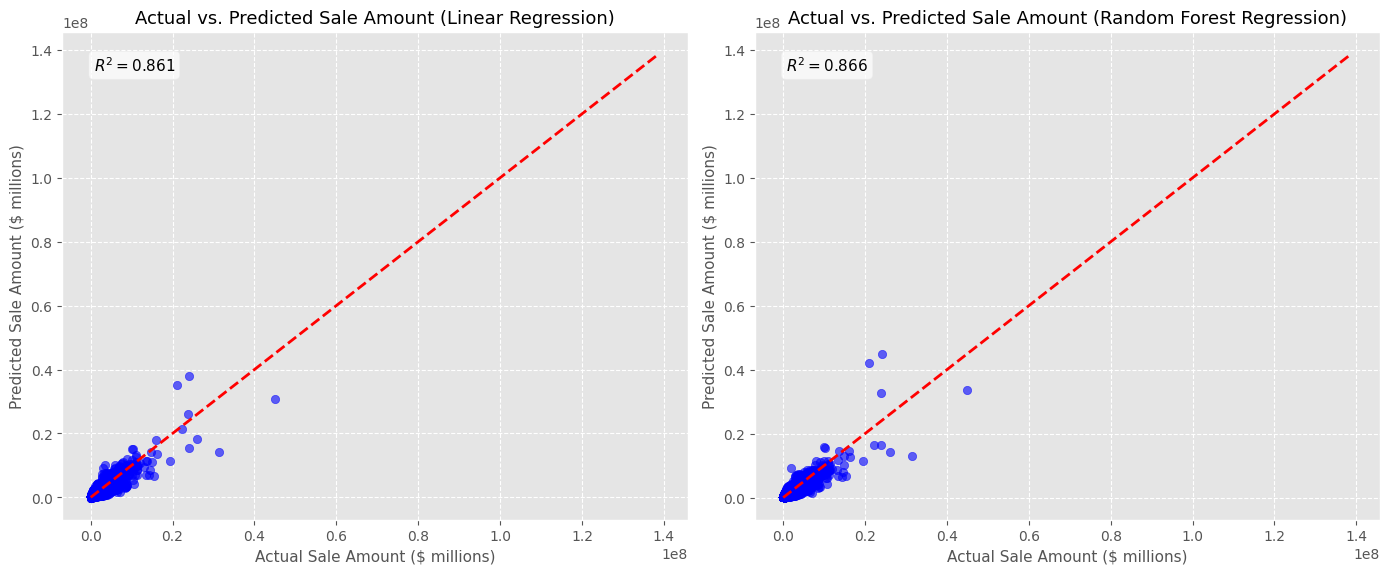

In [31]:
# Plots for Actual vs Predicted Sale Amount

# Calculate R-squared values
r2_reg = r2_score(y_test, y_pred_reg)
r2_rf = r2_score(y_test, y_pred_RF)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression: Actual vs predicted values
ax[0].scatter(y_test, y_pred_reg, color='blue', alpha=0.6)
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax[0].set_xlabel('Actual Sale Amount ($ millions)', fontsize=11)
ax[0].set_ylabel('Predicted Sale Amount ($ millions)', fontsize=11)
ax[0].set_title('Actual vs. Predicted Sale Amount (Linear Regression)', fontsize=13)
ax[0].grid(True, linestyle='--')

# Add R-squared text
ax[0].text(
    0.05, 0.95,
    f'$R^2 = {r2_reg:.3f}$',
    transform=ax[0].transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

# Random Forest Regression: Actual vs predicted values
ax[1].scatter(y_test, y_pred_RF, color='blue', alpha=0.6)
ax[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax[1].set_xlabel('Actual Sale Amount ($ millions)', fontsize=11)
ax[1].set_ylabel('Predicted Sale Amount ($ millions)', fontsize=11)
ax[1].set_title('Actual vs. Predicted Sale Amount (Random Forest Regression)', fontsize=13)
ax[1].grid(True, linestyle='--')

# Add R-squared text
ax[1].text(
    0.05, 0.95,
    f'$R^2 = {r2_rf:.3f}$',
    transform=ax[1].transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

plt.tight_layout()
plt.show()

**Residuals vs Predicted Sale Amount**

Linear regression shows smaller residuals (i.e. better performance) for lower sale amounts and widening residuals for larger sale amounts. There are concerns of heteroscedasticity here. At the high end, the model tended to underpredict the most expensive properties, except the two most expensive properties.

Random forest regression also shows better performance for low sale amounts. Above $1 million, random forest also underpredicted sale amount in general. Interestingly, random forest also badly overpredicted the two most expensive properties.



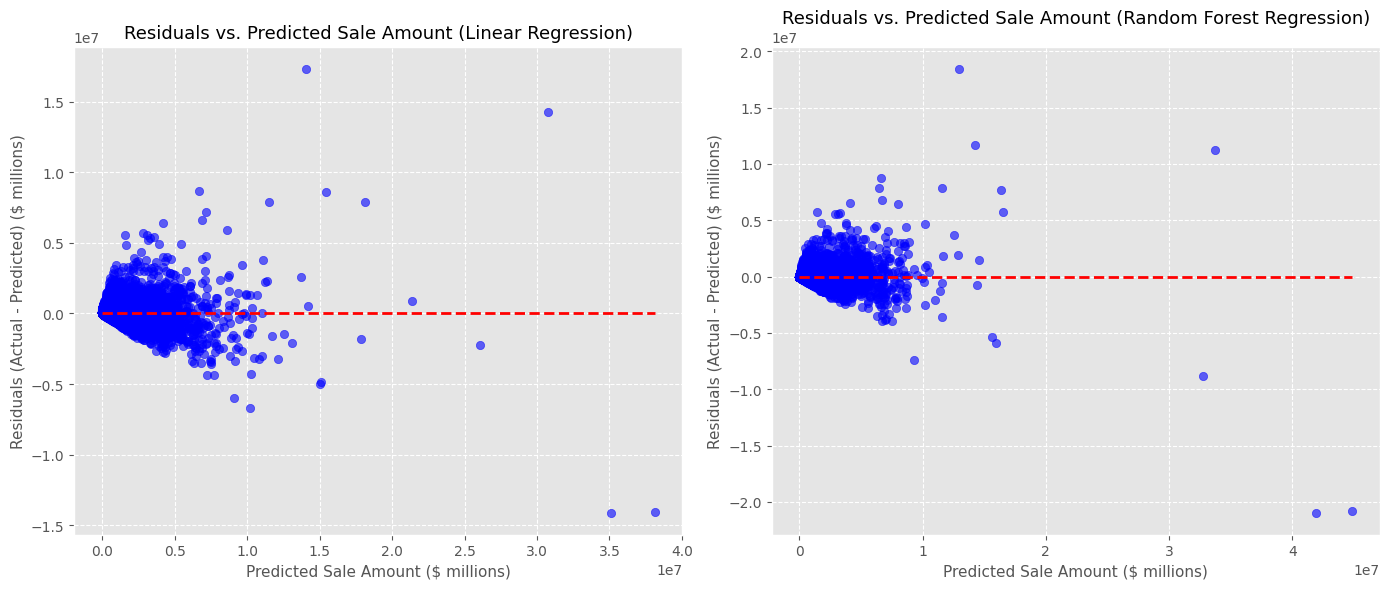

In [32]:
# Plots for Residuals vs Predicted Sale Amount

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression: Residuals vs. Predicted
ax[0].scatter(y_pred_reg, residuals_reg, color='blue', alpha=0.6)
ax[0].hlines(y=0, xmin=y_pred_reg.min(), xmax=y_pred_reg.max(), color='r', linestyles='--', lw=2)
ax[0].set_xlabel('Predicted Sale Amount ($ millions)', fontsize=11)
ax[0].set_ylabel('Residuals (Actual - Predicted) ($ millions)', fontsize=11)
ax[0].set_title('Residuals vs. Predicted Sale Amount (Linear Regression)', fontsize=13)
ax[0].grid(True, linestyle='--')

# Random Forest Regression: Residuals vs. Predicted
ax[1].scatter(y_pred_RF, residuals_RF, color='blue', alpha=0.6)
ax[1].hlines(y=0, xmin=y_pred_RF.min(), xmax=y_pred_RF.max(), color='r', linestyles='--', lw=2)
ax[1].set_xlabel('Predicted Sale Amount ($ millions)', fontsize=11)
ax[1].set_ylabel('Residuals (Actual - Predicted) ($ millions)', fontsize=11)
ax[1].set_title('Residuals vs. Predicted Sale Amount (Random Forest Regression)', fontsize=13)
ax[1].grid(True, linestyle='--')

plt.tight_layout()
plt.show()

**Mean Absolute Residual by Residential Type**

Linear regression and random forest regression performed similarly. Upon closer inspection, it's clear that random forest regression had smaller mean absolute residuals than linear regression for both property types.

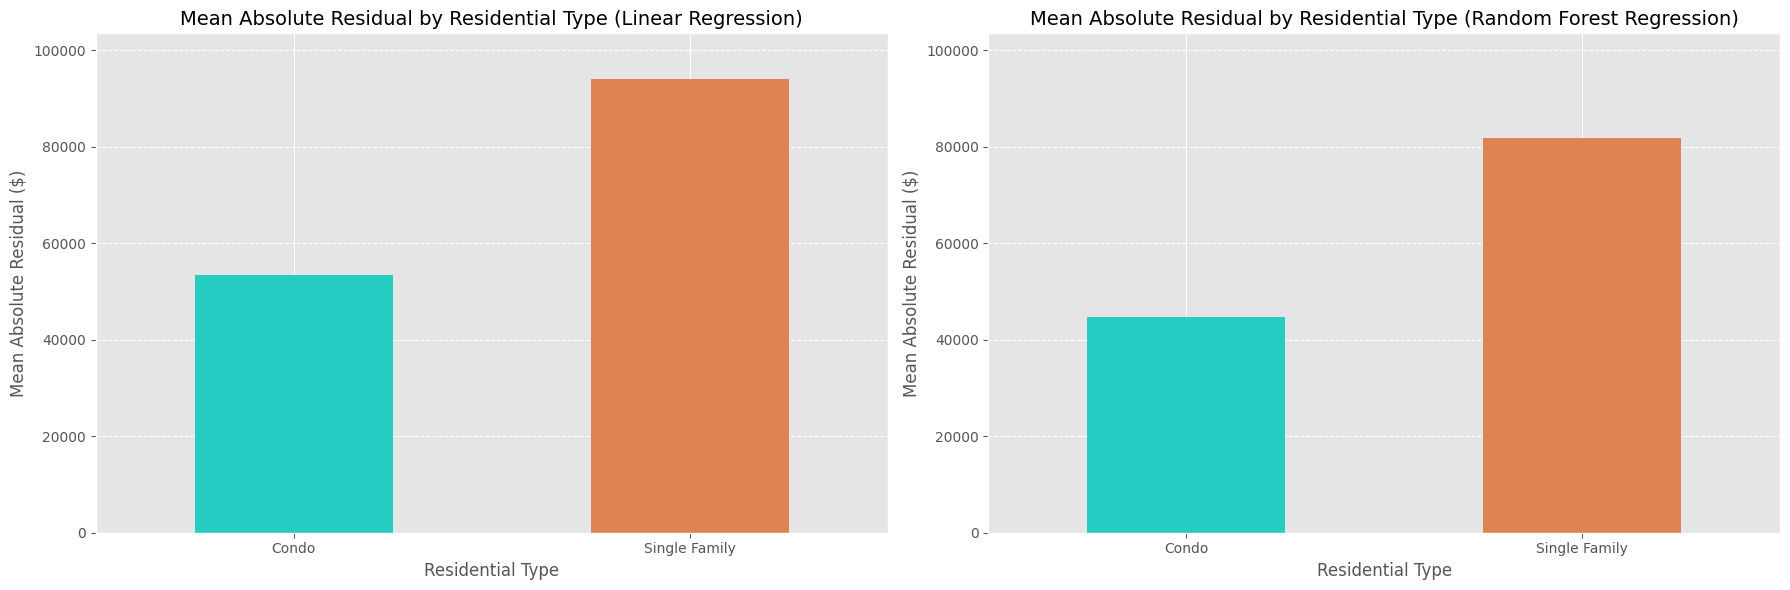

In [33]:
# Plots for Linear Regression: Mean Absolute Residual by Residential Type

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
mean_abs_residual_type_RF = residual_by_residential_type_RF['absolute_residual']['mean'].sort_values()

# Compute a common y-axis max, with a little extra headroom
y_max = 1.1 * max(
    mean_abs_residual_type.max(),
    mean_abs_residual_type_RF.max()
)

# Linear Regression: Mean Absolute Residual by Residential Type
mean_abs_residual_type.plot(
    kind='bar',
    ax=ax[0],
    color=[condo_color, single_family_color],
    capsize=4,
)

ax[0].set_xlabel('Residential Type', fontsize=12)
ax[0].set_ylabel('Mean Absolute Residual ($)', fontsize=12)
ax[0].set_title('Mean Absolute Residual by Residential Type (Linear Regression)', fontsize=14)
ax[0].tick_params(axis='x', rotation=0)
ax[0].grid(axis='y', linestyle='--')
ax[0].set_ylim(0, y_max)

# Random Forest Regression: Residuals by residential type (mean absolute residual)
mean_abs_residual_type_RF.plot(
    kind='bar',
    ax=ax[1],
    color=[condo_color, single_family_color],
    capsize=4,
)

ax[1].set_xlabel('Residential Type', fontsize=12)
ax[1].set_ylabel('Mean Absolute Residual ($)', fontsize=12)
ax[1].set_title('Mean Absolute Residual by Residential Type (Random Forest Regression)', fontsize=14)
ax[1].tick_params(axis='x', rotation=0)
ax[1].grid(axis='y', linestyle='--')
ax[1].set_ylim(0, y_max)

plt.tight_layout()
plt.show()

**Mean Absolute Residual by Assessed Value Quintiles**

Here too, we see that random forest regression had smaller values than linear regression across every quintile.

For both models, we see relatively steady mean absolute residuals for quintiles 1 through 4, but quintile 5 is showing significantly larger values. This is likely due to the presence of many outliers in the highest quintile.

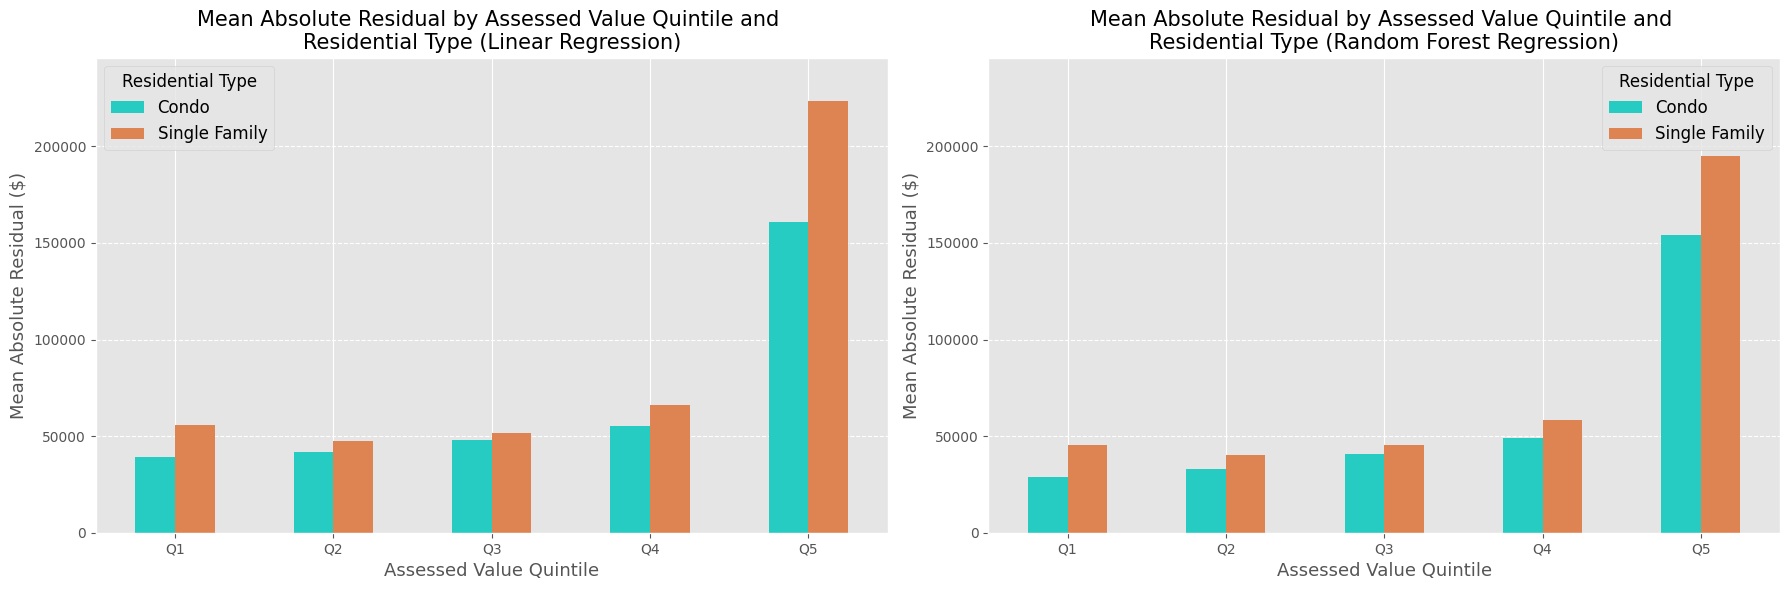

In [34]:
# Plots of Mean Absolute Residual by Assessed Value Quintiles

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Unstack variables so I can plot them in a grouped bar chart
residual_pivot = df_test_results.groupby(['assessed_value_quintile', 'residential_type'], observed=False)['absolute_residual'].mean().unstack()
residual_pivot_RF = df_test_results_RF.groupby(['assessed_value_quintile', 'residential_type'], observed=False)['absolute_residual'].mean().unstack()

# Compute a common y-axis max, with a little extra headroom
y_max = 1.1 * max(
    residual_pivot.max().max(),
    residual_pivot_RF.max().max()
)

# Linear Regression: Grouped bar chart
residual_pivot.plot(
    kind='bar',
    ax=ax[0],
    color=[condo_color, single_family_color],
    capsize=4,
)

ax[0].set_title('Mean Absolute Residual by Assessed Value Quintile and \nResidential Type (Linear Regression)', fontsize=15)
ax[0].set_xlabel('Assessed Value Quintile', fontsize=13)
ax[0].set_ylabel('Mean Absolute Residual ($)', fontsize=13)
ax[0].tick_params(axis='x', rotation=0)
ax[0].legend(title='Residential Type', fontsize=12, title_fontsize=12)
ax[0].grid(axis='y', linestyle='--')
ax[0].set_ylim(0, y_max)

# Unstack variables so I can plot them in a grouped bar chart
residual_pivot_RF = df_test_results_RF.groupby(['assessed_value_quintile', 'residential_type'], observed=False)['absolute_residual'].mean().unstack()

# Random Forest Regression: Grouped bar chart
residual_pivot_RF.plot(
    kind='bar',
    ax=ax[1],
    color=[condo_color, single_family_color],
    capsize=4,
)

ax[1].set_title('Mean Absolute Residual by Assessed Value Quintile and \nResidential Type (Random Forest Regression)', fontsize=15)
ax[1].set_xlabel('Assessed Value Quintile', fontsize=13)
ax[1].set_ylabel('Mean Absolute Residual ($)', fontsize=13)
ax[1].tick_params(axis='x', rotation=0)
ax[1].legend(title='Residential Type', fontsize=12, title_fontsize=12)
ax[1].grid(axis='y', linestyle='--')
ax[1].set_ylim(0, y_max)

plt.tight_layout()
plt.show()

**Absolute Residuals by Residential Type and Assessed Value Quintile (Log10 scale)**

In this box plot, we also see that quintiles 1 through 4 have similar absolute residuals. Quintile 5 has clearly higher values. We see outliers to the right in every quintile. Quintile 5's outliers are the most extreme.

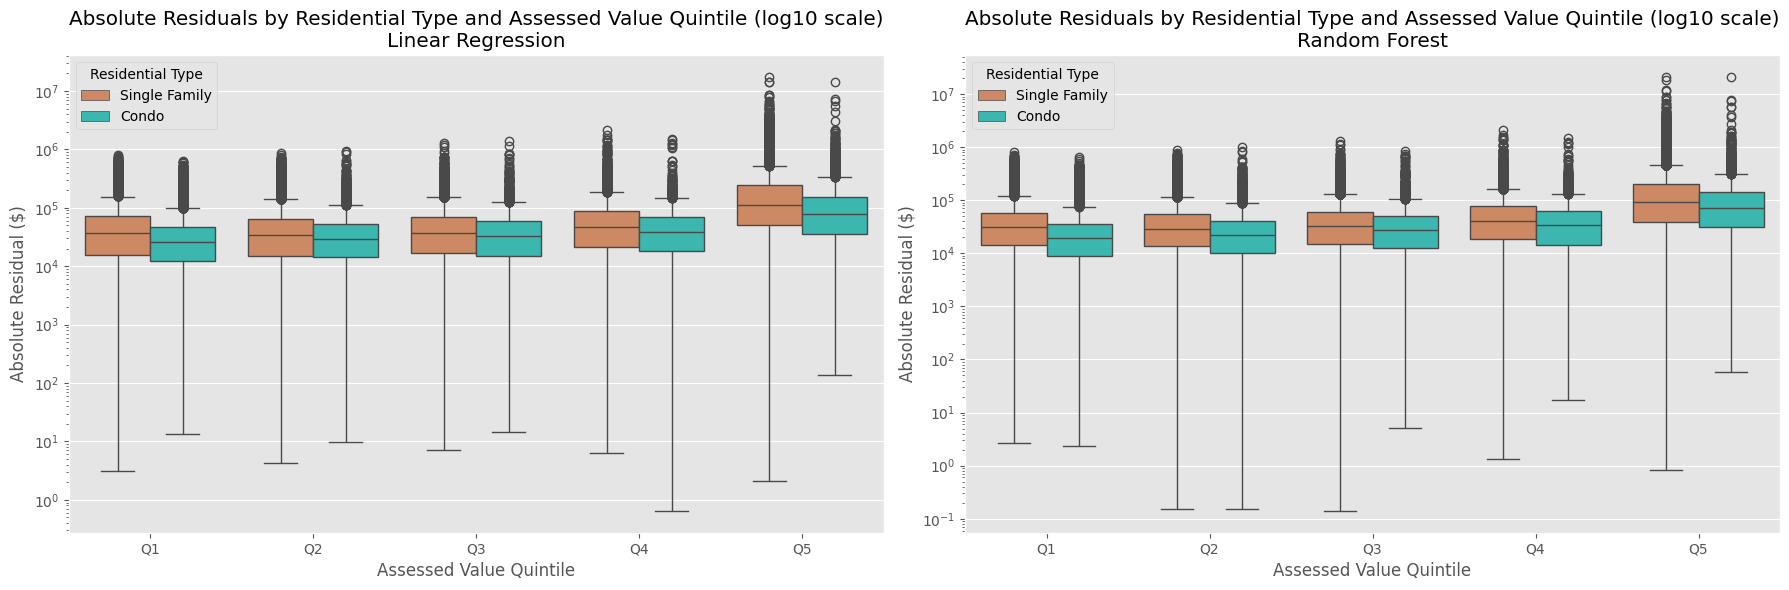

In [35]:
# Box Plot of Absolute Residuals by residential type and assessed value quintile
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(
    data=df_test_results,
    x='assessed_value_quintile',
    y='absolute_residual',
    hue='residential_type',
    palette={'Condo': condo_color, 'Single Family': single_family_color},
    showfliers=True,
    ax=ax[0],
)

ax[0].set_yscale('log')
ax[0].set_title('Absolute Residuals by Residential Type and Assessed Value Quintile (log10 scale)\nLinear Regression')
ax[0].set_xlabel('Assessed Value Quintile')
ax[0].set_ylabel('Absolute Residual ($)')
ax[0].legend(title='Residential Type')


sns.boxplot(
    data=df_test_results_RF,
    x='assessed_value_quintile',
    y='absolute_residual',
    hue='residential_type',
    palette={'Condo': condo_color, 'Single Family': single_family_color},
    showfliers=True,
    ax=ax[1],
)

ax[1].set_yscale('log')
ax[1].set_title('Absolute Residuals by Residential Type and Assessed Value Quintile (log10 scale)\nRandom Forest')
ax[1].set_xlabel('Assessed Value Quintile')
ax[1].set_ylabel('Absolute Residual ($)')
ax[1].legend(title='Residential Type')
plt.tight_layout()
plt.show()

**Evaluating results:**

Random Forest had a smaller R-squared value for actual vs predicted sale amount, smaller mean absolute residuals by residential type, and smaller mean absolute residuals by assessed value quintile. For this dataset, random forest regression performed slightly better than linear regression.

Mean absolute residuals were larger for single family homes than for condos. This actually makes sense, since single family homes are larger than condos. The residuals will be larger, too.

For quintiles 1 through 4, we saw relatively steady mean absolute residuals. Then in quintile 5, we saw significantly larger mean absolute residuals. Both models performed very poorly with data points from quintile 5. I would not trust these models to reliably handle datasets such as this one with extreme outliers to the right. That makes sense. Regression type models are sensitive to outliers.

**Revisiting my hypothesis:**

My hypothesis was as follows: "As house size decreases, the predictability of sales price of housing decreases."

For this, I decided to compare mean absolute residuals. Mean absolute residuals are a pretty good proxy for the predictability of prices, since they measure the prediction error within each group. Higher mean absolute residuals equate to worse predictions.

The results turned out to be exactly the opposite of my hypothesis. I thought prediction error would decrease for larger homes and that the entry-level portion of the market would have more error. As it turns out, the luxury market was actually much more difficult to predict on average than entry-level homes, at least in Connecticut. Quintile 5 had significantly larger mean absolute residuals than the other quintiles.

This raises questions about heteroscedasticity in real estate markets. In other words, the residuals do not have consistent spread over our range of assessed value. A quick search on Google brings up many studies and papers that have aimed to study the issue of heteroscedasticity in real estate markets. As it turns out, this is an issue in real estate that has been studied for decades.

**What would I do differently in the future?**

I would find a better proxy for size, rather than relying on proxies such as residential type and assessed value price quintiles. Square footage and the number of bedrooms and bathrooms would be better choices.

I'm also interested to see data from other markets and whether those other markets follow similar trends.

Finally, a time series analysis might be interesting. It might enable me to study certain time periods, like the housing bust that accompanied the great financial crisis.